## Pipeline Exploration with team and player stats
This notebook includes PCA pipelines with logistic regression, NN, decision tree and naive bayes.  It is the same work as Peipeline_team_stats but it includes overall player data as well in the modeling.



In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc
from numpy import interp
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [2]:
#Get CSV's into memory
df_team = pd.read_csv("2019_all_delta_extra.csv")
team_runs = {}

def get_teams():
    teams = [item.strip() for item in open("all_teams.txt",'r')]
    return teams

teams = get_teams()

df_team.head()

,Date,Home_Win,Home,Away,Win Percent Delta,Streak Delta,Run Scored Delta,Run Allowed Delta,Run Delta Delta,Run Delta Percent Delta,Win Total Delta
0,thursday mar 28,W,OAK,LAA,0.000000,-2,11,14,-3,0.7857,0
1,friday mar 29,L,OAK,LAA,0.333333,2,15,10,5,1.0714,1
2,saturday mar 30,W,OAK,LAA,-0.250000,-2,11,14,-3,-0.1500,0
3,sunday mar 31,W,OAK,LAA,0.066667,2,13,12,1,0.1545,1
4,monday apr 1,W,SEA,LAA,0.583333,4,39,23,16,0.6214,4


In [3]:
df_player = pd.read_csv("2012-2019_team_player_stats.csv",index_col='Team Abbreviation')
df_player[df_player['Year'] == 2019].head()

,Team Name,Year,League,Division,Games,Wins,Loses,Ties,Win_Percentage,Games_Back,Runs_Scored,Runs_Allowed,AVG,OBP,SLG,BFW,O_AVG,O_OBP,O_SLG
Team Abbreviation,,,,,,,,,,,,,,,,,,,
ATL,Atlanta Braves,2019,National,East,162,97,65,0,0.599,-,855,743,0.258,0.336,0.452,5.0,0.256,0.329,0.419
WSN,Washington Nationals,2019,National,East,162,93,69,0,0.574,4,873,724,0.265,0.342,0.454,3.4,0.244,0.314,0.412
PHI,Philadelphia Phillies,2019,National,East,162,81,81,0,0.500,16,774,794,0.246,0.319,0.427,-3.0,0.261,0.332,0.453
NYM,New York Mets,2019,National,East,162,86,76,0,0.531,11,791,737,0.257,0.328,0.442,4.9,0.251,0.317,0.418
MIA,Miami Marlins,2019,National,East,162,57,105,0,0.352,40,615,808,0.241,0.298,0.375,-16.6,0.245,0.329,0.435


In [4]:
df_all = pd.read_csv("2019_all_stats.csv")

In [5]:
X = df_all.loc[:,df_all.columns[4:]].values
y = df_all.loc[:,df_all.columns[1]].values

In [6]:
X.shape

(2429, 21)

In [7]:
#create win/loss mask
wins = df_all.loc[:,'Home_Win'] == 'W'
losses = df_all.loc[:,'Home_Win'] != 'W'

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
scaler = StandardScaler()
X_transform = scaler.fit_transform(X)
le = LabelEncoder()
y_label = le.fit_transform(y)
le.transform(['W','L'])

array([1, 0], dtype=int64)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
    train_test_split(X_transform, y_label, 
                     test_size=0.25,
                     stratify=y_label,
                     random_state=1)

In [10]:
from numpy import array
from numpy import mean
from numpy import cov
from numpy.linalg import eig
# define a matrix
A = array(X_transform)

# calculate the mean of each column
M = mean(A.T, axis=1)

# center columns by subtracting column means
C = A - M

# calculate covariance matrix of centered matrix. This is how much each columns varies with other columns
V = cov(C.T)

# eigendecomposition of covariance matrix.  The larger the eigenvalue, the more it matters
values, vectors = eig(V)
print(f'Eigenvalues: {values}')

# project data using the covariance matrix and the eigenvectors
P = vectors.T.dot(C.T)

xval = np.array([item[0] for item in P.T])
yval = np.array([item[1] for item in P.T])

Eigenvalues: [ 8.50344538e+00  4.21089999e+00  2.31601000e+00  1.63439266e+00
  1.09220833e+00  7.91904885e-01  6.95471984e-01  4.05739908e-01
  2.42348883e-01  2.25031253e-01  1.87815349e-01  1.65463326e-01
  1.37591480e-01  2.81101265e-02  3.26328359e-02  4.53606898e-02
  8.70896457e-02  7.90948749e-02  6.31888422e-02  6.48486518e-02
 -2.56337978e-17]


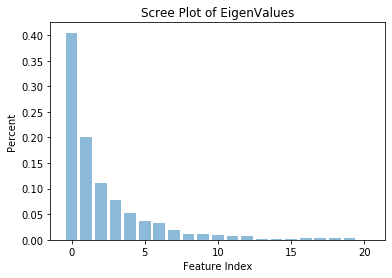

In [11]:
def create_scree(vector):
    total = sum(vector)
    percent = vector/total
    return percent

import matplotlib.pyplot as plt

plt.title('Scree Plot of EigenValues')
plt.ylabel('Percent')
plt.xlabel('Feature Index')
plt.bar([x for x in range(len(values))], create_scree(values), align='center', alpha=0.5)
plt.show()

In [12]:
#confirming results with sklearn package
pca = PCA(n_components=5, svd_solver='full')
pca.fit(X_transform)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)


[0.40475927 0.2004365  0.11024079 0.07779618 0.05198851]
[143.6884316  101.11411962  74.98848097  62.99448687  51.49642536]


In [27]:
# no value for PCA components
pipe_lr = make_pipeline(PCA(),
                        LogisticRegression(penalty='l2', 
                                           solver='lbfgs',
                                           max_iter=10000,
                                           C=21.54,
                                           tol=0.1))
pipe_lr.fit(X_train,y_train)
print(f'PCA components unset: {round(pipe_lr.score(X_test,y_test),3)}')
pipe_lr2 = make_pipeline(PCA(n_components=4),
                        LogisticRegression(penalty='l2', 
                                           solver='lbfgs',
                                           max_iter=10000,
                                           C=21.54,
                                           tol=0.1))
pipe_lr2.fit(X_train,y_train)
print(f'PCA components set to 2: {round(pipe_lr2.score(X_test,y_test),3)}')

PCA components unset: 0.562
PCA components set to 2: 0.551


In [28]:
scores = cross_val_score(estimator=pipe_lr,
                         X=X_transform,
                         y=y_label,
                         cv=10,
                         n_jobs=1)
#print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
scores = cross_val_score(estimator=pipe_lr2,
                         X=X_transform,
                         y=y_label,
                         cv=10,
                         n_jobs=1)
#print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.590 +/- 0.031
CV accuracy: 0.592 +/- 0.041


### Grid search indicates that n components of 4 should be best, but when I don't set that variable in the pipeline it actually performs better

Best parameter (CV score=0.610):
{'logistic__C': 0.046415888336127774, 'pca__n_components': 4}


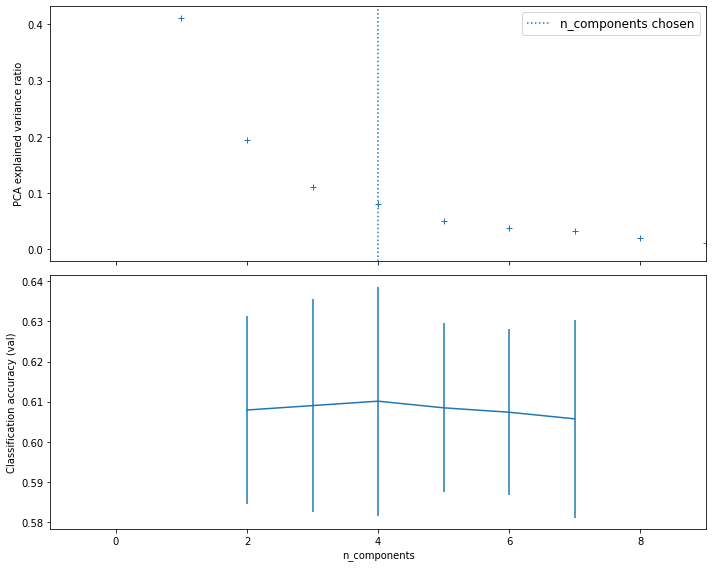

In [14]:
from sklearn.model_selection import GridSearchCV

# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [2, 3, 4, 5, 6, 7],
    'logistic__C': np.logspace(-4, 4, 4),
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Plot the PCA spectrum
pca.fit(X_train)


fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(10, 8))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(-1, 9)

plt.tight_layout()
plt.show()

## There is little separation of the data using PCA

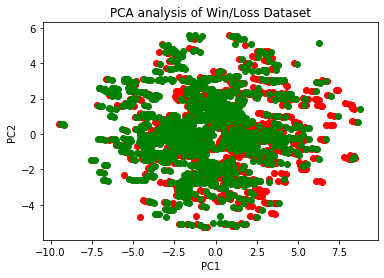

In [15]:
import matplotlib.pyplot as plt

#plot loses as red and wins as green
plt.scatter(xval[losses], yval[losses], color='red')                            
plt.scatter(xval[wins], yval[wins], color='green')

plt.title('PCA analysis of Win/Loss Dataset')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig("Images\\PCA_21.png")
plt.show()

## PCA --> Logistic Pipeline

In [143]:
pipe_lr = make_pipeline(PCA(n_components=2),
                        LogisticRegression(penalty='l2', 
                                           solver='lbfgs',
                                           max_iter=10000,
                                           C=21.54,
                                           tol=0.1))
pipe_lr.fit(X_train,y_train)
pipe_lr.score(X_test,y_test)

0.5526315789473685

## This is the best result I have gotten for all these features... About the same as the NN ~59%.
I am surprised that having 21 features is not as good as the 7

In [144]:
#sklearn has a cross validator built in so we don't need to loop through things manuially
scores = cross_val_score(estimator=pipe_lr,
                         X=X_transform,
                         y=y_label,
                         cv=10,
                         n_jobs=1)
#print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.592 +/- 0.037


This is about 4% higher than the other pipeline, and unlike the NN it's accuracy does not change with each iteration

# PCA -> NN Pipeline

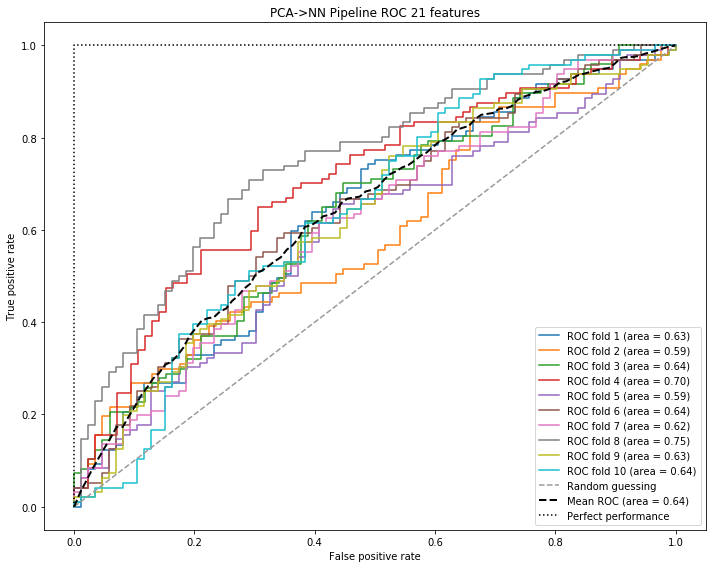

In [18]:
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        MLPClassifier(activation = "logistic", 
                                      solver='sgd',
                                      learning_rate_init = 0.1,
                                      learning_rate = "constant",
                                      momentum = 0.1,
                                      max_iter = 10000))
                    
# here we are selecting only 2 features from the dataset
X_train2 = X_train
#[:, [0,2,3]]
    
#You can set the cross validator here with the number of splits
cv = list(StratifiedKFold(n_splits=10).split(X_train, y_train))

fig = plt.figure(figsize=(10, 8))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    #Xtrain2 is used here for the fit, using only the features chosen above.  If you use the Xtrain data it will get 100%
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title("PCA->NN Pipeline ROC 21 features" )
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.savefig('Images\\ROC_21.png')
plt.show()

## NN results
You'll get slightly different results each time you cross validate, but overall the NN seems to achieve consistently better than 59.5% accuracy --> 1.5% better than the naive assumption.  Still not great, but oh well

In [146]:
#sklearn has a cross validator built in so we don't need to loop through things manuially
for i in range(0,10):
    scores = cross_val_score(estimator=pipe_lr,
                             X=X_transform,
                             y=y_label,
                             cv=10,
                             n_jobs=1)
    #print('CV accuracy scores: %s' % scores)
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.602 +/- 0.040
CV accuracy: 0.595 +/- 0.041
CV accuracy: 0.595 +/- 0.033
CV accuracy: 0.591 +/- 0.030
CV accuracy: 0.595 +/- 0.038
CV accuracy: 0.590 +/- 0.043
CV accuracy: 0.598 +/- 0.032
CV accuracy: 0.594 +/- 0.033
CV accuracy: 0.596 +/- 0.032
CV accuracy: 0.592 +/- 0.028


The PCA-> NN achieves 59% accuracy

# Naive Bayes

In [26]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
print(f'Accuracy: {round(1-((y_test != y_pred).sum()/X_test.shape[0]),3)}')
gnb.score(X_test, y_test)

Number of mislabeled points out of a total 608 points : 268
Accuracy: 0.559


0.5592105263157895

### NB shows a 1.5% accuracy improvement with this larger dataset - 59.5%

In [20]:
scores = cross_val_score(estimator=gnb,
                             X=X_transform,
                             y=y_label,
                             cv=5,
                             n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.61522634 0.55967078 0.59053498 0.61522634 0.59587629]
CV accuracy: 0.595 +/- 0.020


### Putting Naive Bayes into a pipeline with PCA does not do anything for the final results, unsurprisingly

In [21]:
pipe_lr = make_pipeline(PCA(),
                        GaussianNB())
pipe_lr.fit(X_train, y_train)

scores = cross_val_score(estimator=gnb,
                             X=X_transform,
                             y=y_label,
                             cv=5,
                             n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.61522634 0.55967078 0.59053498 0.61522634 0.59587629]
CV accuracy: 0.595 +/- 0.020


## Decision Tree
Performs worse with more data

In [22]:
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=5, 
                                    random_state=1)
tree_model.fit(X_train, y_train)
scores = cross_val_score(estimator=tree_model,
                             X=X_transform,
                             y=y_label,
                             cv=10,
                             n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.60493827 0.59670782 0.57201646 0.51851852 0.5308642  0.59259259
 0.55144033 0.59670782 0.59670782 0.61983471]
CV accuracy: 0.578 +/- 0.032


### Putting the PCA into the decision tree did, however, result in a slight improvement (probably negligible)

In [23]:
pipe_lr = make_pipeline(PCA(),
                        DecisionTreeClassifier(criterion='gini',
                                               max_depth=3,
                                               random_state=1))
pipe_lr.fit(X_train, y_train)
scores = cross_val_score(estimator=pipe_lr,
                             X=X_transform,
                             y=y_label,
                             cv=10,
                             n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.59670782 0.63786008 0.57201646 0.48148148 0.55144033 0.61728395
 0.56790123 0.65843621 0.57201646 0.57024793]
CV accuracy: 0.583 +/- 0.047


## PCA --> NN

In [25]:
pipe_lr = make_pipeline(PCA(),
                        MLPClassifier(activation = "logistic", 
                                      solver='sgd',
                                      learning_rate_init = 0.1,
                                      learning_rate = "constant",
                                      momentum = 0.1,
                                      max_iter = 10000))
pipe_lr.fit(X_train, y_train)
for i in range(5):
    scores = cross_val_score(estimator=pipe_lr,
                                 X=X_transform,
                                 y=y_label,
                                 cv=10,
                                 n_jobs=1)
    #print('CV accuracy scores: %s' % scores)
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.597 +/- 0.034
CV accuracy: 0.593 +/- 0.033
CV accuracy: 0.597 +/- 0.029
CV accuracy: 0.597 +/- 0.039
CV accuracy: 0.597 +/- 0.031


## LDA --> NN
Similar results to PCA --> NN

In [24]:
pipe_lr = make_pipeline(LDA(),
                        MLPClassifier(activation = "logistic", 
                                      solver='sgd',
                                      learning_rate_init = 0.1,
                                      learning_rate = "constant",
                                      momentum = 0.1,
                                      max_iter = 10000))
pipe_lr.fit(X_train, y_train)
for i in range(5):
    scores = cross_val_score(estimator=pipe_lr,
                                 X=X_transform,
                                 y=y_label,
                                 cv=10,
                                 n_jobs=1)
    #print('CV accuracy scores: %s' % scores)
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.590 +/- 0.032
CV accuracy: 0.588 +/- 0.029
CV accuracy: 0.587 +/- 0.029
CV accuracy: 0.591 +/- 0.031
CV accuracy: 0.592 +/- 0.028


## LDA

In [184]:
lda = LDA()
lda.fit(X_train,y_train)
scores = cross_val_score(estimator=lda,
                             X=X_transform,
                             y=y_label,
                             cv=10,
                             n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.6090535  0.60493827 0.55555556 0.55967078 0.5308642  0.60493827
 0.61316872 0.6255144  0.58436214 0.62809917]
CV accuracy: 0.592 +/- 0.031
